## Task:

Create a model that optimizes team formations based on known data (basic dog data, dog order, obstacle height, weather conditions).

## Solution method:

- Based on previous analyses, individual run times can be estimated with the best accuracy (3%), so I will investigate the ideal conditions and the best options for team formation from this point of view
- I use a Gradient Boosting regression model for model building, and then determine the most optimal value of each variable using Partial Dependence method. Finally, I collect the most optimal set-up in a table.

# Import data

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import basic data with weather variables
dog_perf = pd.read_csv('./../data/cleaned/race_data_with_weather.csv')
dog_perf


,hurdle_height,name,chng,time,track,location,when,championship,temperature,humidity,precipitation,wind_speed,wind_gusts,breed,sex,castrated,age
0,25.0,Sunny,-0.24,4.21,0,Heroltice,2023-04-22 10:11:57,cz,15.6,49,0.0,7.1,18.0,belgian shepherd - malinois,female,neutral,4
1,25.0,Brooke,-0.11,4.08,1,Heroltice,2023-04-22 10:11:57,cz,15.6,49,0.0,7.1,18.0,border,male,sexual,3
2,25.0,Sunny,0.02,4.25,0,Heroltice,2023-04-22 10:13:25,cz,15.6,49,0.0,7.1,18.0,belgian shepherd - malinois,female,neutral,4
3,25.0,Brooke,-0.63,4.25,1,Heroltice,2023-04-22 10:13:25,cz,15.6,49,0.0,7.1,18.0,border,male,sexual,3
4,25.0,Sunny,-0.06,4.21,0,Heroltice,2023-04-22 10:15:06,cz,15.6,49,0.0,7.1,18.0,belgian shepherd - malinois,female,neutral,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4383,27.5,Alfie,error,4.01,0,Vodňany,2023-10-15 16:02:38,cz,9.5,60,0.0,18.8,40.0,australian shepperd,female,neutral,6
4384,27.5,Alex,0,4.22,1,Vodňany,2023-10-15 17:14:50,cz,9.2,58,0.1,21.9,42.8,border,male,neutral,10
4385,27.5,Alex,0.18,4.16,1,Vodňany,2023-10-15 17:15:52,cz,9.2,58,0.1,21.9,42.8,border,male,neutral,10
4386,27.5,Alex,NaN,4.17,1,Vodňany,2023-10-15 17:17:08,cz,9.2,58,0.1,21.9,42.8,border,male,neutral,10


# Preprocessing data

In [5]:
# Convert chng and time variables to numeric variable type
dog_perf_num = dog_perf[['name','chng','time','breed','track', 'championship' ,'temperature','humidity','precipitation','wind_speed','wind_gusts', 'sex','castrated','hurdle_height','age','location']].copy()
numeric_columns = ['chng','time']
dog_perf_num[numeric_columns] = dog_perf_num[numeric_columns].apply(pd.to_numeric, errors='coerce')
dog_perf_num['when'] = dog_perf['when'].astype('datetime64[ns]')

In [6]:
# Create new variable for time of day: agea morning, late morning, agea afternoon, late afternoon
time_of_day = []
def time_conversion(time):
    
    if time.hour < 10:
        time_of_day='early_morning'
    elif time.hour >= 10 and time.hour < 12:
        time_of_day='late_morning'
    elif time.hour >= 12 and time.hour < 15:
        time_of_day='early_afternoon'
    else:
        time_of_day='late_afternoon'
        
    return time_of_day 

time_of_day.append(dog_perf_num['when'].map(time_conversion))
time_of_day

[0         late_morning
 1         late_morning
 2         late_morning
 3         late_morning
 4         late_morning
              ...      
 4383    late_afternoon
 4384    late_afternoon
 4385    late_afternoon
 4386    late_afternoon
 4387    late_afternoon
 Name: when, Length: 4388, dtype: object]

In [7]:
# discard irrelevant variables and append the time of day information to the original table
dog_perf_num.drop(['when','chng','championship','location'],axis=1, inplace=True)
dog_perf_num = pd.concat([dog_perf_num, pd.DataFrame(time_of_day).T], axis=1)

In [8]:
# First I create dummy values for the object type variables (using one-hot encoding), so that the machine learning model can handle these dimensions properly
dog_perf_num_nums = dog_perf_num.select_dtypes(exclude='object')
dog_perf_num_objs =  dog_perf_num.select_dtypes(include='object')

dog_perf_num_objs = pd.get_dummies(dog_perf_num_objs,drop_first=True)

dog_perf_num_encoded = pd.concat([dog_perf_num_nums,dog_perf_num_objs],axis=1)
dog_perf_num_encoded

,time,track,temperature,humidity,precipitation,wind_speed,wind_gusts,hurdle_height,age,name_Agnes,...,breed_parson russell terrier,breed_patterdale terrier,breed_sheltie,breed_small schnauzer,breed_whippet,sex_male,castrated_sexual,when_early_morning,when_late_afternoon,when_late_morning
0,4.21,0,15.6,49,0.0,7.1,18.0,25.0,4,False,...,False,False,False,False,False,False,False,False,False,True
1,4.08,1,15.6,49,0.0,7.1,18.0,25.0,3,False,...,False,False,False,False,False,True,True,False,False,True
2,4.25,0,15.6,49,0.0,7.1,18.0,25.0,4,False,...,False,False,False,False,False,False,False,False,False,True
3,4.25,1,15.6,49,0.0,7.1,18.0,25.0,3,False,...,False,False,False,False,False,True,True,False,False,True
4,4.21,0,15.6,49,0.0,7.1,18.0,25.0,4,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4383,4.01,0,9.5,60,0.0,18.8,40.0,27.5,6,False,...,False,False,False,False,False,False,False,False,True,False
4384,4.22,1,9.2,58,0.1,21.9,42.8,27.5,10,False,...,False,False,False,False,False,True,False,False,True,False
4385,4.16,1,9.2,58,0.1,21.9,42.8,27.5,10,False,...,False,False,False,False,False,True,False,False,True,False
4386,4.17,1,9.2,58,0.1,21.9,42.8,27.5,10,False,...,False,False,False,False,False,True,False,False,True,False


# Fit ML model

In [10]:
#Question: which dogs to race and under what conditions?

# Create a regression model for individual run times
X= dog_perf_num_encoded[dog_perf_num_encoded['time'].isna() == 0][['track', 'temperature', 'humidity', 'precipitation',
       'wind_speed', 'wind_gusts', 'hurdle_height', 'age',
       'name_Agnes',
       'name_Alex', 'name_Alfie', 'name_Angie', 'name_Apollo', 'name_Ashley',
       'name_Bailey', 'name_Bella', 'name_Bonnie', 'name_Bree', 'name_Brix',
       'name_Brooke', 'name_Bruno', 'name_Cookies', 'name_Dexter',
       'name_Dixie', 'name_Dusty', 'name_Easy', 'name_Enola', 'name_Falco',
       'name_Fleur', 'name_Gerry', 'name_Gordon', 'name_Hank', 'name_Hector',
       'name_Henry', 'name_Jasper', 'name_Jessie', 'name_Kent', 'name_Kesha',
       'name_Maggie', 'name_Mason', 'name_Milo', 'name_Moon', 'name_Negro',
       'name_Nina', 'name_Pax', 'name_Punk', 'name_Rex', 'name_Riley',
       'name_Rocky', 'name_Sara', 'name_Scotty', 'name_Sirius', 'name_Speedy',
       'name_Sunny', 'name_Ted', 'name_Them', 'name_Tyna',
       'breed_australian kelpie', 'breed_australian shepperd',
       'breed_belgian shepherd - malinois', 'breed_border',
       'breed_jack russell terrier', 'breed_mix', 'breed_kooikerhondje',
       'breed_mudi', 'breed_parson russell terrier',
       'breed_patterdale terrier', 'breed_sheltie', 'breed_small schnauzer',
       'breed_whippet',
       'sex_male', 'castrated_sexual', 'when_early_morning', 'when_late_afternoon', 'when_late_morning']].copy()

y = dog_perf_num_encoded['time'].dropna().copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

model = GradientBoostingRegressor(random_state=42,n_estimators=500,max_depth=4,min_samples_leaf=10)
model.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=4, min_samples_leaf=10, n_estimators=500,
                          random_state=42)

In [11]:
np.sqrt(mean_squared_error(y_test,model.predict(X_test))) / (dog_perf_num['time'].mean())   # A modell hibája 6% körüli, mely elegendően pontos

0.057083119081044194

In [12]:
model.feature_names_in_

array(['track', 'temperature', 'humidity', 'precipitation', 'wind_speed',
       'wind_gusts', 'hurdle_height', 'age', 'name_Agnes', 'name_Alex',
       'name_Alfie', 'name_Angie', 'name_Apollo', 'name_Ashley',
       'name_Bailey', 'name_Bella', 'name_Bonnie', 'name_Bree',
       'name_Brix', 'name_Brooke', 'name_Bruno', 'name_Cookies',
       'name_Dexter', 'name_Dixie', 'name_Dusty', 'name_Easy',
       'name_Enola', 'name_Falco', 'name_Fleur', 'name_Gerry',
       'name_Gordon', 'name_Hank', 'name_Hector', 'name_Henry',
       'name_Jasper', 'name_Jessie', 'name_Kent', 'name_Kesha',
       'name_Maggie', 'name_Mason', 'name_Milo', 'name_Moon',
       'name_Negro', 'name_Nina', 'name_Pax', 'name_Punk', 'name_Rex',
       'name_Riley', 'name_Rocky', 'name_Sara', 'name_Scotty',
       'name_Sirius', 'name_Speedy', 'name_Sunny', 'name_Ted',
       'name_Them', 'name_Tyna', 'breed_australian kelpie',
       'breed_australian shepperd', 'breed_belgian shepherd - malinois',
       'breed_

# Partial Dependence bases evaluation

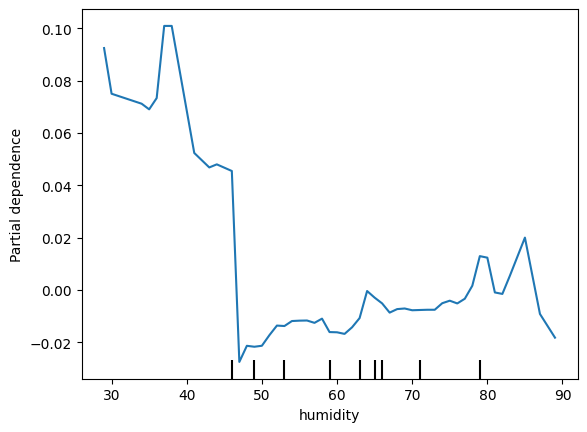

In [13]:
# I manually check PD for a numeric and categorical variable:

PartialDependenceDisplay.from_estimator(model, X, ['humidity'])
# It is observed that a humidity of about 50-60% reduces the running time most according to the model

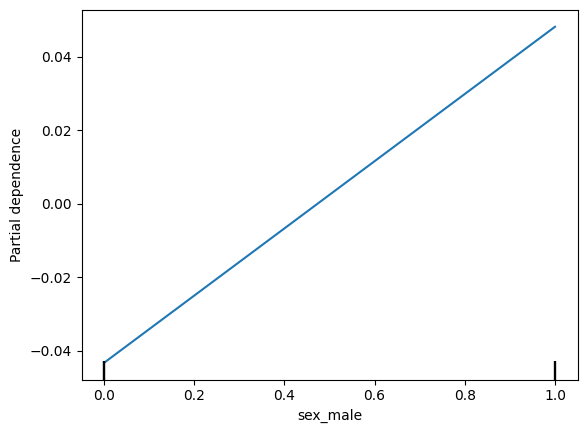

In [14]:
PartialDependenceDisplay.from_estimator(model, X, ['sex_male'])
# It can be observed that the bitch value decreases the target value, i.e. it has a positive effect

### List optimal conditions for each variable

In [15]:
# First, I list the most ideal conditions for the numerical values. I find the minimum of the Partial dependence value and then look at the value there (e.g. temperature). I save the results in a separate table.
best_values = pd.DataFrame(['track', 'temperature', 'humidity', 'precipitation', 'wind_speed', 'wind_gusts', 'hurdle_height', 'age', 'sex_male', 'castrated_sexual'], columns=['feature'])

values = []
for feature in best_values['feature']:
    values.append(partial_dependence(model, X, [feature])['values'][0][np.argmin(partial_dependence(model, X, [feature])['average'])])

best_values = pd.concat([best_values, pd.DataFrame(values)], axis=1)
best_values.rename(columns={'feature': 'feature', 0:'value'},inplace=True)

In [16]:
# I pick the top 4 dog breeds
best_breeds = pd.DataFrame()
for x in model.feature_names_in_:
    if x.__contains__('breed'):
        best_breeds = pd.concat([best_breeds, pd.DataFrame([x, partial_dependence(model, X, [x])['average'][0][1]]).T])
best_3_b = pd.DataFrame(data = {'feature': ['1. best breed', '2. best breed', '3. best breed', '4. best breed'], 'value': best_breeds.sort_values(by=1)[:4][0].apply(lambda x: x.split('_')[1])})
best_3_b.index = [0,1,2,3]
best_values = pd.concat([best_values, best_3_b], ignore_index=True)

In [20]:
# I'll pick out the top 4 dogs
best_dogs = pd.DataFrame()
for x in model.feature_names_in_:
    if x.__contains__('name'):
        best_dogs = pd.concat([best_dogs, pd.DataFrame([x, partial_dependence(model, X, [x])['average'][0][1]]).T])
best_3_d = pd.DataFrame(data = {'feature': ['1. best dog', '2. best dog', '3. best dog', '4. best dog'], 'value': best_dogs.sort_values(by=1)[:4][0].apply(lambda x: x.split('_')[1])})
best_3_d.index = [0,1,2,3]
best_values = pd.concat([best_values, best_3_d], ignore_index=True)

In [21]:
# I determine the best time of day to race
best_time = pd.DataFrame()
for x in model.feature_names_in_:
    if x.__contains__('when'):
        best_time = pd.concat([best_time, pd.DataFrame([x, partial_dependence(model, X, [x])['average'][0][1]]).T])

best_values = pd.concat([best_values, pd.DataFrame(data={'feature': 'time of day', 'value': best_time[0].iloc[np.argmin(best_time[1])]}, index=[0])], ignore_index=True)

# Result: most optimal configuration

In [24]:
# The most optimal conditions and composition in terms of individual running time
best_values

,feature,optimal vale
0,pálya színe,red
1,hőmérséklet,6.8
2,páratartalom,47
3,csapadékmennyiség,0.0
4,szélsebesség,8.4
5,széllökés erősség,50.0
6,akadálymagasság,25.0
7,age,2
8,sex_male,female
9,castrated_sexual,sexual
